## Plotting Kernel Density Estimate values for more than one 2D dataset on the same plot

This tutorial was inspired by my difficulty in finding a few more detailed tutorials on how to plot Kernel density estimates data of more than one 2D dataset in the same figure. I used the following references as a base for this code: 

1. [scikit-learn documentation of sklearn.neighbors.KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity)

2. An outdated (with respect to import libraries at least) in depth discussion about KDE. 
[In-Depth: Kernel Density Estimation by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

3. [plotly 3D scatter plots](https://plot.ly/python/3d-scatter-plots/) to plot interactive 3D scatter plots and [plotting multiple charts in the same plot](https://plot.ly/python/graphing-multiple-chart-types/) (not necessarily different types).

Also, there is this interesting paper that shows the plotting option I think to be the most suitable for the case I will show here. 

4. [Marques, J. C., Lackner, S., Félix, R. & Orger, M. B. Structure of the Zebrafish Locomotor Repertoire Revealed with Unsupervised Behavioral Clustering. Current Biology 28, 181-195.e5 (2018).](https://doi.org/10.1016/j.cub.2017.12.002)

In [1]:
import numpy as np
import plotly as py
import plotly.graph_objects as go
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#set pyplot to notebook mode
py.offline.init_notebook_mode(connected=True)

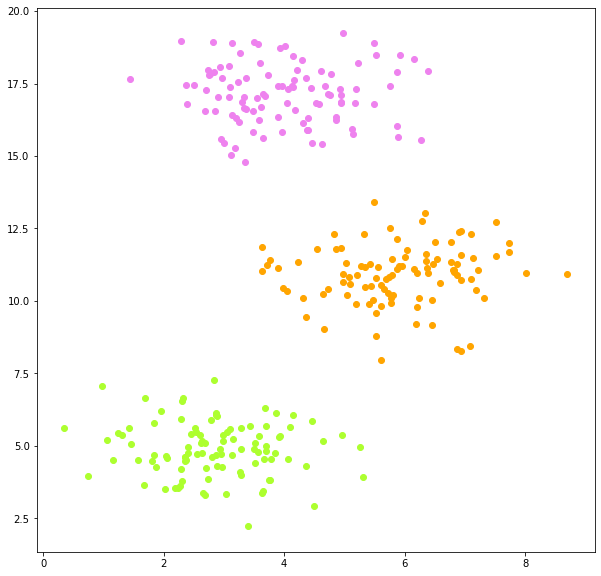

In [2]:
np.random.seed(0)

sample = np.random.randn(300,2)
# alter x, y positions with pos_modifier
pos_modifier = np.random.randint(20,size=(3,2))

# split into 3 groups and modify the position based on pos_modifier
split_sample = np.split(sample,3)
split_sample = [split_sample[i]+pos_modifier[i,:].T for i in range(3)]
mod_sample = np.concatenate(split_sample)

# create labels 
l = np.array([1,2,3])
labels = np.repeat(l,100)
labels

colors = ['violet', 'greenyellow', 'orange']

#show datapoints in 2D
plt.figure(figsize=(10,10))
for i in range(len(l)):
    plt.scatter(mod_sample[labels==l[i],0],mod_sample[labels==l[i],1], color=colors[i])
plt.show()



We can start with an execise of computing the densities of the merged dataset (without labels) in both axes. 

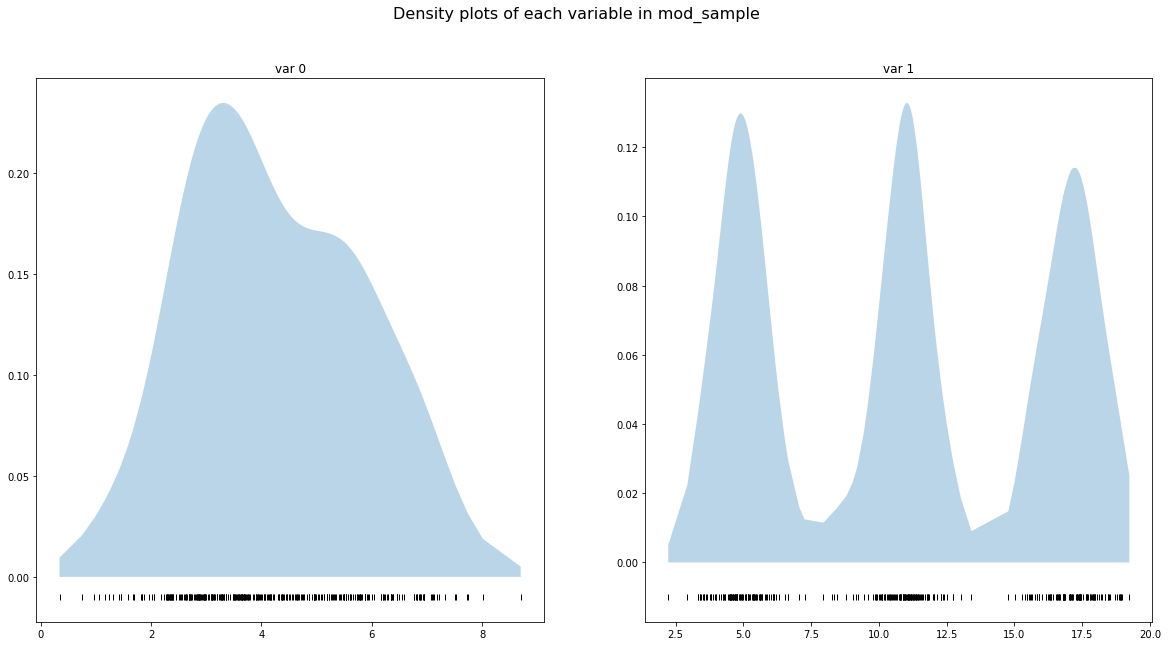

In [3]:
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')

nobs, nvar = mod_sample.shape

fig = plt.figure(figsize=(20, 10))
plt.suptitle("Density plots of each variable in mod_sample", fontsize=16)
for var in range(nvar):
    
    data = np.reshape(mod_sample[:,var],(nobs,1))
    
    kde.fit(data)
    density = np.exp(kde.score_samples(data))
    
    ax = fig.add_subplot(121 + var)
    
    # sort to plot with fill_between
    density = np.reshape([x for _,x in sorted(zip(mod_sample[:,var],density))],(nobs,))
    plt.fill_between(sorted(mod_sample[:,var]), density, interpolate=True, alpha=0.3)
    # plot black bars below the density plot
    plt.plot(data, np.full_like(data, -0.01), '|k', markeredgewidth=1)
    plt.title("var %i" % var)
    

Note that the bandwidth will change how the densities will look like considerably, similarly to the regular 1D histogram. First, I just tested a few values and the value 0.5 is roughly what looked ok (no strict optimization). I just looked ad how the data varied in both dimensions and tried some values. 

You may find an optimal value of bandwidth if you use the cross validation tools from `sklearn.model_selection`. We are going to do this later on.

Now let's compute KDE including both variables. 

In [4]:
# using plotly graph objects 'go'
fig = go.Figure()
for i in range(len(l)):

    data = mod_sample[labels==l[i],:]
    
    # construct a gaussian kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(data)
    
    Z = np.exp(kde.score_samples(data))
    #Z = Z.reshape(X.shape)
   
    # plot contours of the density
    #levels = np.linspace(0, Z.max(), 15)
    #ax.scatter(Y, Y, Z, levels=levels, colors=cmaps[i])
    fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=Z, name=str(l[i]) , mode='markers', 
                               marker=dict(size=3,
                                           color=colors[i],  # set color to an array/list of desired values
                                           opacity=0.8))) 
    
py.offline.iplot(fig)

In this case, I think it would be possible to merge the three datasets and show a contour plot of the data and mark manually each dataset based on a centroid value. But this is not true when we think of datasets that are not well separated as this one. 

In [5]:
fig = go.Figure()

#calculate centroid with list comprehension
centroids = np.asarray([np.mean(mod_sample[labels==l[i],:],axis=0) for i in range(len(l))])
    
# construct a gaussian kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(mod_sample)

density = np.exp(kde.score_samples(mod_sample))
#Z = Z.reshape(X.shape)

fig.add_trace(go.Scatter3d(x=mod_sample[:,0], y=mod_sample[:,1], z=density, name=str(l[i]) , mode='markers', 
                           marker=dict(size=3,
                                       color='blue',  # set color to an array/list of desired values
                                       opacity=0.5))) 

max_density = [np.max(density[labels==l[i],]) for i in range(len(l))]

fig.add_trace(go.Scatter3d(x=centroids[:,0], y=centroids[:,1], z=max_density, name=str(l[i]) , mode='markers', 
                           marker=dict(size=5,
                                       color=colors,  # set color to an array/list of desired values
                                       opacity=0.8)))
py.offline.iplot(fig)

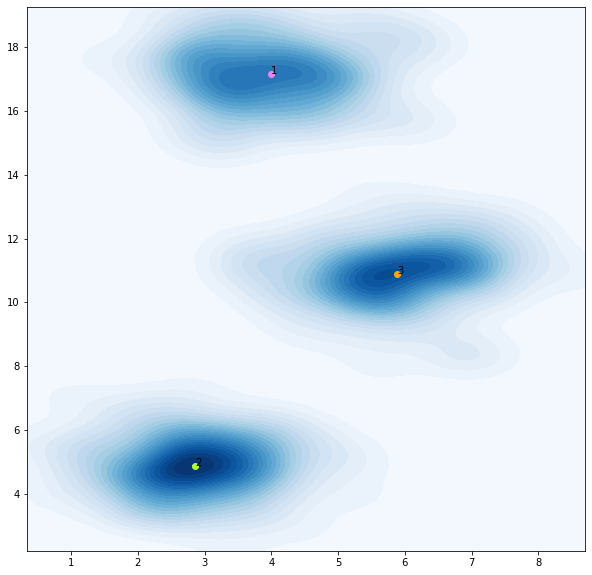

In [6]:
# for some reason densities look strange if I use only the mod_sample
# datapoints to create a mesh
#X, Y = np.meshgrid(mod_sample[:,0], mod_sample[:,1]) 

xx = np.linspace(min(mod_sample[:,0]),max(mod_sample[:,0]),1000)
yy = np.linspace(min(mod_sample[:,1]),max(mod_sample[:,1]),2000)
X, Y = np.meshgrid(xx, yy) 
xy = np.vstack([X.ravel(), Y.ravel()]).T

density = np.exp(kde.score_samples(xy)).reshape(X.shape)

# define the number of contour levels and their valyes (25 values from 0 to maximum density value)
levels = np.linspace(0, density.max(), 25)

plt.figure(figsize=(10,10))
plt.contourf(X, Y, density, levels=levels, cmap='Blues')
for i in range(len(l)):
    plt.scatter(centroids[i,0], centroids[i,1], color=colors[i])
    plt.annotate(l[i], (centroids[i,0], centroids[i,1]))
    
plt.show()

If you have up to three different datasets and they are also well separated, you could still try to plot the data as an image, by using an RGB channel per dataset. But I am not going to show this here. 

# Exploring spatial distribution of observed species in Kenya 1994-1996

We have got data from the spatial distribution of Giraffes, Elephants and Wildebeest (Gnu) in Kenya from 1994-1996 from the World Resources Institute. The three datasets werae available separately through http://datasets.wri.org/dataset/ (CC BY-NC 4.0) in shl format, and we converted the datasets to x,y positions (not related to geographical coordinate systems) to make it easier to use. 

In [7]:
# loading datasets and creating labels (1,2, and 3)
df1 = np.genfromtxt('./ke_numbers_giraffe.csv', delimiter=',', skip_header=1)
l1 = np.ones((len(df1),1))
df2 = np.genfromtxt('./ke_numbers_elephant.csv', delimiter=',', skip_header=1)
l2 = np.ones((len(df2),1))*2
df3 = np.genfromtxt('./ke_numbers_wildebeest.csv', delimiter=',', skip_header=1)
l3 = np.ones((len(df3),1))*3

In [8]:
# erging into a single numpy array
spatial_data = np.vstack((df1,df2,df3))
labels = np.vstack((l1,l2,l3))
labels = labels.reshape((len(labels),))
labels_legend = dict(enumerate(['giraffe', 'elephant', 'wildebeest'],1))

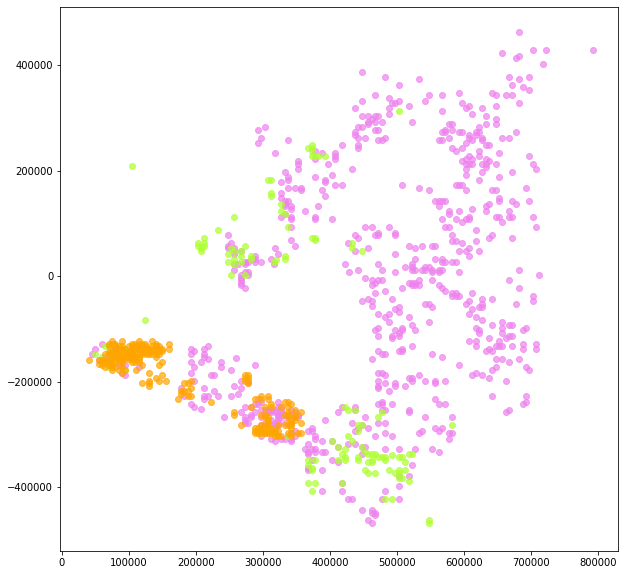

In [9]:
colors = ['violet', 'greenyellow', 'orange']

#show datapoints in 2D
plt.figure(figsize=(10,10))
for i in range(len(l)):
    plt.scatter(spatial_data[labels[:,]==l[i],0],spatial_data[labels[:,]==l[i],1], color=colors[i], alpha=0.7)
plt.show()

In this case, there are more differences between the datasets, giraffe observations are more widespread but still dense in some regions, whereas elephant and wildebeest observations are more concentrated in specific areas of the country. Also, elephant observations appear to be sparser than the wildebeest observations.

Now, we are not sure what will be the optimal values of bandwidth for each of these datasets, so we are going to estimate a range of values to be tested and use `sklearn.model_selection.GridSearchCV` to find the best bandwidth value. 

In [10]:
fig = go.Figure() 

for i in range(len(l)):
    row, col = spatial_data.shape
    delta = np.array((col,1))
    
    for col in range(col):
        delta[col] = np.max(spatial_data[labels == l[i],col]) - np.min(spatial_data[labels == l[i],col])
        print('difference between maximum and minimum values ',delta[col])
        
    max_delta = np.max(delta)
    print('max bandwidth value to be tested is 1/3 of the max observed among all variables', max_delta/3)
    
    # find log10 of the maximum bandwidth value
    max_log = np.log10(max_delta)
    # vary 3 orders of magnitude to test optimal bandwith 
    bandwidths = 10 ** np.linspace(np.floor(max_log-3),max_log,300)
    
    data = spatial_data[labels == l[i],:]
    #now test bandwidths and get the optimal 
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
    grid.fit(data)
    print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    kde = grid.best_estimator_
    
    density = np.exp(kde.score_samples(data))
    
    fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=density, name=labels_legend[i+1] , mode='markers', 
                               marker=dict(size=3,
                                           color=colors[i],  # set color to an array/list of desired values
                                           opacity=0.8))) 
    
py.offline.iplot(fig)

difference between maximum and minimum values  747910
difference between maximum and minimum values  930000
max bandwidth value to be tested is 1/3 of the max observed among all variables 310000.0
best bandwidth: 16463.05932473581
difference between maximum and minimum values  532900
difference between maximum and minimum values  780000
max bandwidth value to be tested is 1/3 of the max observed among all variables 260000.0
best bandwidth: 27176.045221163455
difference between maximum and minimum values  317895
difference between maximum and minimum values  179936
max bandwidth value to be tested is 1/3 of the max observed among all variables 105965.0
best bandwidth: 8336.524635784608


In [29]:
from ndtest import *
import itertools 

for i, j in itertools.combinations(l,2):
    print('Testing 2D KS between',labels_legend[i],' and ',labels_legend[j])
    p = ks2d2s(spatial_data[labels == l[i-1],0],spatial_data[labels == l[i-1],1],spatial_data[labels == l[j-1],0],spatial_data[labels == l[j-1],1])
    print('p value',p)

Testing 2D KS between giraffe  and  elephant
p value 1.0211052001699647e-21
Testing 2D KS between giraffe  and  wildebeest
p value 3.4608045656284306e-62
Testing 2D KS between elephant  and  wildebeest
p value 8.387312350146048e-25


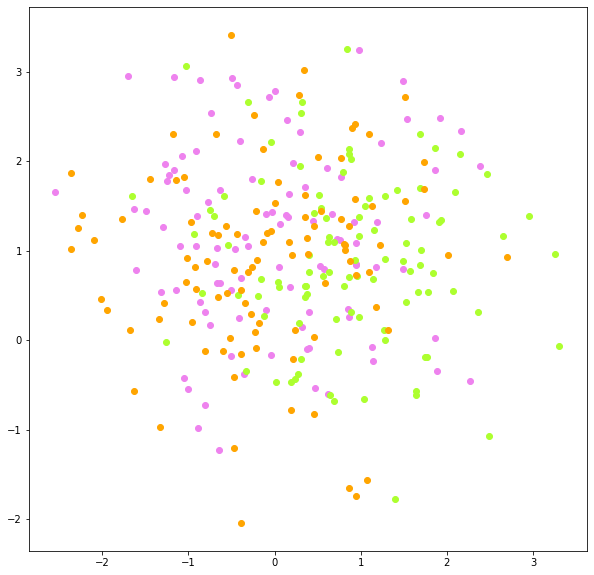

In [39]:
np.random.seed(0)

sample = np.random.randn(300,2)
# alter x, y positions with pos_modifier
pos_modifier = np.random.randint(2,size=(3,2))

# split into 3 groups and modify the position based on pos_modifier
split_sample = np.split(sample,3)
split_sample = [split_sample[i]+pos_modifier[i,:].T for i in range(3)]
mod_sample = np.concatenate(split_sample)

# create labels 
labels = np.repeat(l,100)
labels

colors = ['violet', 'greenyellow', 'orange']

#show datapoints in 2D
plt.figure(figsize=(10,10))
for i in range(len(l)):
    plt.scatter(mod_sample[labels==l[i],0],mod_sample[labels==l[i],1], color=colors[i])
plt.show()

In [43]:
for i, j in itertools.combinations(l,2):
    print('Testing 2D KS between',labels_legend[i],' and ',labels_legend[j])
    p = ks2d2s(mod_sample[labels == l[i-1],0],mod_sample[labels == l[i-1],1],mod_sample[labels == l[j-1],0],mod_sample[labels == l[j-1],1])
    print('p value',p)

Testing 2D KS between giraffe  and  elephant
p value 2.3940413168807728e-05
Testing 2D KS between giraffe  and  wildebeest
p value 0.19219574499893155
Testing 2D KS between elephant  and  wildebeest
p value 7.114083893701931e-06


In [46]:
# using plotly graph objects 'go'
fig = go.Figure()
for i in range(len(l)):

    data = mod_sample[labels==l[i],:]
    
    # construct a gaussian kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(data)
    
    Z = np.exp(kde.score_samples(data))
    #Z = Z.reshape(X.shape)
   
    # plot contours of the density
    #levels = np.linspace(0, Z.max(), 15)
    #ax.scatter(Y, Y, Z, levels=levels, colors=cmaps[i])
    fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=Z, name=str(l[i]) , mode='markers', 
                               marker=dict(size=3,
                                           color=colors[i],  # set color to an array/list of desired values
                                           opacity=0.8))) 
    
py.offline.iplot(fig)